In [ ]:
# on main.py, without plotting stuff (plt, sns)
import json
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Dict
import matplotlib.pyplot as plt

color = "#507bbf"
plt.style.use("bmh")

## Data Processing

In [ ]:
# on params.py
features_dict = {
    "stfmjob":  "How satisfied are you in your main job",
    "trdawrk":  "Too tired after work to enjoy things like doing at home, how often",
    "jbprtfp":  "Job prevents you from giving time to partner/family, how often",
    "pfmfdjba": "Partner/family fed up with pressure of your job, how often",
    "dcsfwrka": "Current job: can decide time start/finish work",
    "wrkhome":  "Work from home or place of choice, how often",
    "wrklong":  "Employees expected to work overtime, how often",
    "wrkresp":  "Employees expected to be responsive outside working hours, how often",
    "health":   "Subjective general health",
    "stfeco":   "How satisfied with present state of economy in country",
    "hhmmb":    "Number of people living regularly as member of household",
    "hincfel":  "Feeling about household's income nowadays",
    "trstplc":  "Trust in the police",
    "sclmeet":  "How often socially meet with friends, relatives or colleagues",
    "hlthhmp":  "Hampered in daily activities by illness/disability/infirmity/mental problem",
    "sclact":   "Take part in social activities compared to others of same age",
    "iphlppl":  "Important to help people and care for others well-being",
    "ipsuces":  "Important to be successful and that people recognise achievements",
    "ipstrgv":  "Important that government is strong and ensures safety",
    "gndr"   :  "Gender",
    "cntry"  :  "Country",
    "happy":    "Happiness"
}

In [ ]:
# on data.py

data = pd.read_csv(
    "/home/mehrshad/code/arthurcornelio88/how-happy"
    +"-in-europe/data/20240319_ESS10_manually-filtered_arthurcornelio88.csv"
).reset_index(drop=True)
data = data.drop("Unnamed: 0", axis=1)
data = data[~data["happy"].isin([77, 88, 99])]

with open("../data/features_table.json", 'r') as file:
    features_tables = json.load(file)

/tmp/ipykernel_13451/66283325.py:1: DtypeWarning: Columns (82,88,90) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(


In [ ]:
#on data.py

def json_to_df(features_json: Dict, feature: str) -> pd.DataFrame:
    """
    Converts a specified feature from a JSON object into a pandas DataFrame. The function expects the feature to be
    represented as a dictionary within the JSON object, where each key-value pair corresponds to an entity's identifier
    and its description, respectively. It creates a DataFrame with two columns: one for the identifiers (appending '_key'
    to the feature name) and one for the descriptions (appending '_desc' to the feature name), ensuring that identifiers
    are of integer type and descriptions are of string type.

    Parameters:
    -----------
    df : pd.DataFrame
        The original DataFrame to be enriched.
    enrichment_df : pd.DataFrame
        The DataFrame containing additional information for the enrichment, with columns named 'feature_key' and 'feature_desc'.

    Returns:
    -------
    pd.DataFrame
        The enriched DataFrame with additional descriptive information merged on the specified feature.
    """
    feature_dict = features_json[feature]
    df = pd.DataFrame.from_dict(
        feature_dict,
        columns=["val"],
        orient="index").reset_index()
    df.columns = [feature+"_key", feature+"_desc"]
    df[feature+"_key"] = df[feature+"_key"].astype(int)
    df[feature+"_desc"] = df[feature+"_desc"].astype(str)
    return df

def enrich_df(df: pd.DataFrame, enrichment_df: pd.DataFrame) -> pd.DataFrame:
    """
    Enriches a given DataFrame by merging it with another DataFrame that contains additional information for one of its
    features. The function automatically identifies the feature to be enriched based on the naming convention used in the
    'enrichment_df' (expects 'feature_key'). It performs a left merge on the specified feature, effectively adding the
    descriptive information from 'enrichment_df' into 'df' and dropping the redundant key column from the merge.

    Parameters:
    -----------
    df : pd.DataFrame
        The original DataFrame to be enriched.
    enrichment_df : pd.DataFrame
        The DataFrame containing additional information for the enrichment, with columns named 'feature_key' and 'feature_desc'.

    Returns:
    -------
    pd.DataFrame
        The enriched DataFrame with additional descriptive information merged on the specified feature.
    """
    feature = enrichment_df.columns[0].replace("_key", "")
    return df.merge(
        enrichment_df,
        how="left",
        left_on=feature,
        right_on=feature+"_key"
    ).drop(feature+"_key", axis=1)

def remove_star_vals(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    """
    Cleans the input DataFrame by removing rows where the description of a specified feature is marked with an asterisk ("*").
    It calculates and prints the percentage of rows being removed because of this placeholder value. This step is crucial for
    cleaning the dataset by eliminating entries with non-informative placeholder values, ensuring data quality for further
    analysis or modeling.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame to be cleaned.
    feature : str
        The feature whose descriptions are to be examined for placeholder values.

    Returns:
    -------
    pd.DataFrame
        A DataFrame excluding rows with placeholder descriptions for the specified feature.
    """
    mask = df[feature+"_desc"] == "*"
    print(f"{feature} %rows: " + str(len(df[mask]) / len(df) * 100))
    return df[~mask]

In [ ]:
#on data.py

def create_map(arr: np.ndarray) -> Dict:
    aux_vals = np.arange(1, arr[-1] // 2 + 1)
    if len(arr)%2 == 0:
        aux_vals = np.concatenate([-np.flip(aux_vals), aux_vals])
    else:
        aux_vals = np.concatenate([-np.flip(aux_vals) - 1, np.array([1]), aux_vals + 1])
    dict_map = {}
    for ind, el in enumerate(arr):
        dict_map[el] = aux_vals[ind]
    return dict_map

# Merging stopped HERE 25/03/2024 15:10

In [ ]:
# rescale features from negative values to positive
# values such that they are symmetric e.g. happiness
# is from 0 to 10 we rescale it to -5 to 5
aux_data = data[features_dict.keys()].copy()
features_map_dict = {}
for feature in features_dict.keys():
    if feature == "cntry":
        continue
    if feature == "wrklong":
        aux_data.loc[aux_data[feature] == 55, feature] = 66
    aux_df = json_to_df(features_tables, feature)
    aux_data = enrich_df(aux_data, aux_df)
    aux_data = remove_star_vals(aux_data, feature)

    mask = aux_data[feature+"_desc"] == "-1"
    vals = np.sort(aux_data[~mask][feature].unique())
    if 0 in vals:
        aux_data.loc[~mask, feature] += 1
        vals += 1
    map_dict = create_map(vals)
    features_map_dict[feature] = map_dict
    aux_data[feature] = aux_data[feature].replace(map_dict)
    aux_data.loc[mask, feature] = 0
    if len(vals)%2 == 1:
        indices = aux_data[aux_data[feature] == 1].index.to_list()
        indices = np.random.choice(indices, len(indices)//2)
        aux_data.loc[aux_data.index.isin(indices), feature] = -1
aux_data = aux_data.reset_index(drop=True)

stfmjob %rows: 0.8155432957543776
trdawrk %rows: 0.29557973935241166
jbprtfp %rows: 0.3234065489826169
pfmfdjba %rows: 0.8354738407462484
dcsfwrka %rows: 0.41171338204820596
wrkhome %rows: 0.2573579739904175
wrklong %rows: 1.2187422799264362
wrkresp %rows: 0.6696862755995221
health %rows: 0.0755329267610362
stfeco %rows: 1.9009490747221365
hhmmb %rows: 0.2711187214611872
hincfel %rows: 0.9357561882958936
trstplc %rows: 0.43907793633369924
sclmeet %rows: 0.2727325480183369
hlthhmp %rows: 0.25893168858373095
sclact %rows: 1.2134293964938891
iphlppl %rows: 0.6850326276316178
ipsuces %rows: 0.4846142411178832
ipstrgv %rows: 0.6184273422562141
gndr %rows: 0.0
happy %rows: 0.0


In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
cntry_encoded = encoder.fit_transform(aux_data[['cntry']])
encoded_columns = [f"cntry_{category}" for category in encoder.categories_[0]]
cntry_encoded_df = pd.DataFrame(cntry_encoded, columns=encoded_columns)

In [ ]:
aux_data = pd.concat([aux_data.drop("cntry", axis=1), cntry_encoded_df], axis=1)

In [ ]:
print(r"Percentage of total data: %{:.2f}".format(len(aux_data) / len(data) * 100))

Percentage of total data: %88.66


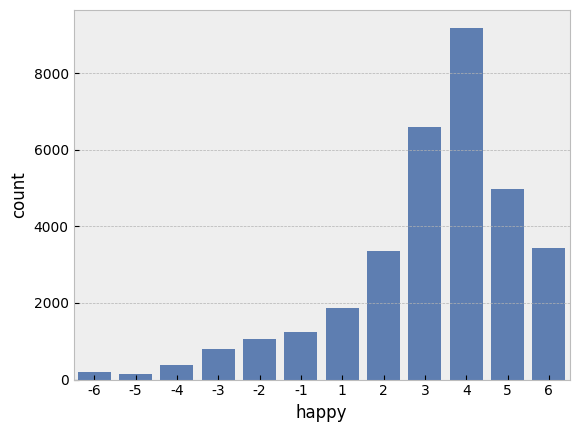

In [ ]:
sns.barplot(aux_data["happy"].value_counts(), color=color);

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmax_X = MinMaxScaler()
minmax_Y = MinMaxScaler()
continuous_cols = [col for col in aux_data.columns if "_desc" not in col and "happy" not in col and "cntry" not in col]
cntry_cols = [col for col in aux_data.columns if "cntry" in col]
aux_data[continuous_cols] = minmax_X.fit_transform(aux_data[continuous_cols])
aux_data["happy"] = minmax_Y.fit_transform(aux_data["happy"].values[:, np.newaxis])

In [ ]:
X = aux_data[continuous_cols + cntry_cols]
y = aux_data["happy"].values[:, np.newaxis]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model 

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, accuracy_score

model = xgb.XGBRegressor(
    booster="gbtree",
    n_jobs=4,
    random_state=42,
    verbosity=0,
)

# Fit the classifier to the training data
model.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = model.predict(X_test)

# Calculate the accuracy of the predictions
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

MAE: 0.11990097394226425


## Post-processing

In [ ]:
yy_pred = minmax_Y.inverse_transform(y_pred[:, np.newaxis])

# since `yy_pred` can have values like 0.2 and -0.3
# rounding them would yield 0.0. Hence we handle
# these cases such that the output would be 1 and -1
# respectively. The same thing happens to 6.6 and -6.8
# which yield 7 and -7 respectively but they are not
# in designated range of classes
yy_pred[(yy_pred > 0) & (yy_pred < 1.0)] = 1
yy_pred[(yy_pred > -1) & (yy_pred < 0.0)] = -1
yy_pred[(yy_pred > 6.5)] = 6
yy_pred[(yy_pred < -6.5)] = -6

yy_pred = np.round(yy_pred)
yy_test = minmax_Y.inverse_transform(y_test)
res_flout_df = pd.DataFrame(
    data=np.concatenate([y_pred[:, np.newaxis], y_test], axis=1),
    columns=["pred", "test"]
)

# we use dtype=int because classes are
# integer valued whilst `inverse_transform`
# yields float numbers
res_int_df = pd.DataFrame(
    data=np.concatenate([np.rint(yy_pred), np.rint(yy_test)], axis=1),
    columns=["pred", "test"],
    dtype=int
)

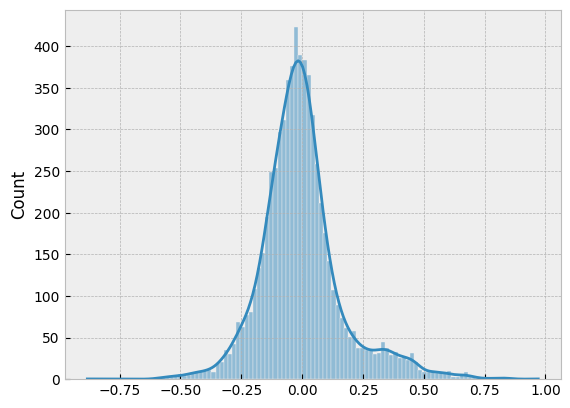

In [ ]:
import seaborn as sns
sns.histplot(res_flout_df["pred"] - res_flout_df["test"], kde=True);

In [ ]:
# create the reverse dictionary map
# for reverting back the -6 to 6 scale
# of happines to the scale of 1 to 11
happy_inverse_map_dict = {}
for key, val in features_map_dict["happy"].items():
    if val == 1:
        happy_inverse_map_dict[-val] = key
        happy_inverse_map_dict[val] = key
    else:
        happy_inverse_map_dict[val] = key

res_int_df["test"] = res_int_df["test"].replace(happy_inverse_map_dict)
res_int_df["pred"] = res_int_df["pred"].replace(happy_inverse_map_dict)

In [ ]:
# this dict map is to reduce the happines
# categories into three general classes of
# unhappy, satisfied and happy
reduce_class_map = {
    1: 0, 2: 0, 3: 0, 4: 0,
    5: 1, 6: 1, 7: 1,
    8: 1, 9: 2, 10: 2, 11: 2
}

res_int_df["test_reduced"] = res_int_df["test"].replace(reduce_class_map)
res_int_df["pred_reduced"] = res_int_df["pred"].replace(reduce_class_map)

In [ ]:
# accuracy for 11 classes of happiness
accuracy_score(res_int_df["test"], res_int_df["pred"]) * 100

30.25702690515557

In [ ]:
# accuracy for 3 classes of happiness
accuracy_score(res_int_df["test_reduced"], res_int_df["pred_reduced"]) * 100

65.92514655042838

In [ ]:
%s/^[A-Z].*//g
%s/\(\d\) \t/\1: "/g
%s/^\*.*//g
%s/Not applicable\*/-1/g
%s/".*/\0",/g
%s/".*\*/"\*/g
%s/^[a-z].*/}, "\0": {/g
%s/^\n//g
%s/,$\n}/}/g
%s/^\(\d\+\)/"\1"/g

UsageError: Line magic function `%s/^[A-Z].*//g` not found.


1. KMeans vs Happiness classification
2. Add country and gender with one hot encoding
3. Use GridSreachCV for cross-validation score